# Topic Modeling with BERT base Sentence Transformer model
* Notebook by Adam Lang
* Date: 8/14/2024

# Overview
* In this notebook we will perform Topic Modeling using `BERTopic`.
* We will also implement the 2021 paper by Liu et al. Open Intent Discovery through Unsupervised Semantic Clustering and Dependency Parsing.
   * Concatenates verbs and nouns by cluster for automatic cluster labeling.
   * Unsupervised 2 stage approach to discover intents and generate meaningful intent labels from unlabeled data.
   * Stages:
      * 1. Semantic clusters - data in each cluster are the same intent. This is done using the metric `balanced score` to determine optimal number of clusters in K-means clustering.
      * 2. Automatic intent labeling of each cluster to extract the ACTION-OBJECT pair from the data.
      * paper link: https://arxiv.org/pdf/2104.12114
* The concept presented in the paper is called `Automatic Cluster Labeling`.
* Fig. 1 from the above paper of the approach to Automatic Cluster Labeling:

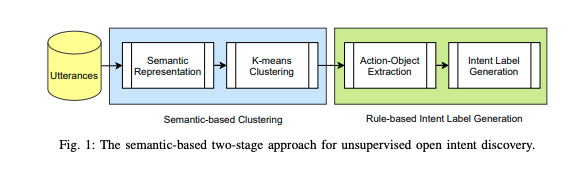

# Dataset Overview
* **Steam Review Dataset (2017)**
* This dataset contains over 6.4 million publicly available reviews in English from Steam Reviews portion of Steam store run by Valve.
* Each review is described by:
  * review text
  * id of game it belongs to
  * review sentiment (positive or negative)
  * number of users who tough review was helpful.
  * This is an extension to previously released Steam Review Dataset.
  * link: https://zenodo.org/records/1000885

In [1]:
## imports
import numpy as np
import pandas as pd
import random as rn
import re #reg ex
import nltk
import os

#plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

## nlp imports
from nltk.corpus import stopwords
from wordcloud import WordCloud

## environ
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# pandas settings
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 400)

In [2]:
# set seed
rn.seed(a=42)

p = 0.004 # to randomly select 0.4% of rows because its very large dataset!

# load data
df_reviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Classical NLP/steam.csv.bz2',
                         skiprows=lambda i: i>0 and rn.random() > p) #randomly skip rows

# print size of dataframe
print(f"The shape of dataframe is: {df_reviews.shape}")

The shape of dataframe is: (25435, 4)


In [3]:
## display df head
display(df_reviews.head())

,10,Ruined my life.,1,0
0,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
1,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
2,10,Game will be played forever,1,0
3,10,i can't stop playing :D,1,0
4,10,Good The best game,1,0


In [4]:
df_reviews.columns

Index(['10', 'Ruined my life.', '1', '0'], dtype='object')

In [5]:
# rename columns
df_reviews.rename(columns={'10': 'app_id',
                          'Ruined my life.': 'review_text',
                          '1': 'review_score',
                          '0': 'review_votes'}, inplace=True)
df_reviews.columns


Index(['app_id', 'review_text', 'review_score', 'review_votes'], dtype='object')

In [6]:
display(df_reviews.head())

,app_id,review_text,review_score,review_votes
0,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
1,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
2,10,Game will be played forever,1,0
3,10,i can't stop playing :D,1,0
4,10,Good The best game,1,0


Summary:
* The 2 most important columns to work with here are:
1. `review_text`
2. `review_score`

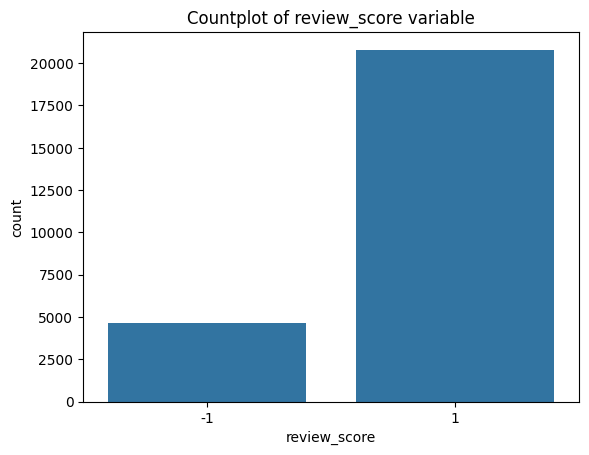

In [8]:
## countplot of review_score
sns.countplot(x='review_score',data=df_reviews)
plt.title('Countplot of review_score variable')
plt.show();

## Pre-processing


In [7]:
## check df info
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25435 entries, 0 to 25434
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   app_id        25435 non-null  int64 
 1   review_text   25393 non-null  object
 2   review_score  25435 non-null  int64 
 3   review_votes  25435 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 795.0+ KB


In [9]:
# check null fields
df_reviews.isna().sum()

,0
app_id,0
review_text,42
review_score,0
review_votes,0


In [10]:
## preprocessing - dtype conversion
df_reviews['review_text'] = df_reviews['review_text'].astype(str)
df_reviews['review_votes'] = df_reviews['review_votes'].astype(str)

# strip white space
df_reviews['review_text'] = df_reviews['review_text'].apply(lambda s: s.strip())

# drop null reviews from review_text
df_reviews_2 = df_reviews[df_reviews['review_text'].notnull()]

# change scores from -1 and 1 --> 1 and 0
df_reviews_2['review_score'] = np.where(df_reviews_2['review_score'] == -1, 0, df_reviews_2['review_score'])

# check head of data
df_reviews_2.head()

,app_id,review_text,review_score,review_votes
0,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
1,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
2,10,Game will be played forever,1,0
3,10,i can't stop playing :D,1,0
4,10,Good The best game,1,0


In [11]:
## check values of review_score
df_reviews_2['review_score'].value_counts()

,count
review_score,
1,20798
0,4637


## Word Cloud Visualization


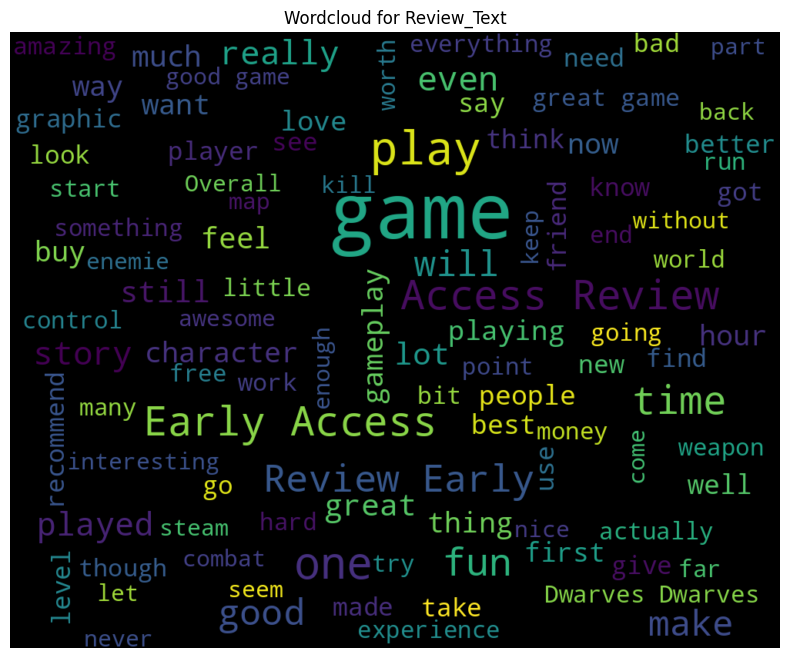

In [12]:
txt = ' '.join(rev for rev in df_reviews_2.review_text)

plt.figure(figsize=(16,8))

# wordcloud
wordcloud = WordCloud(
    background_color='black',
    max_font_size=100,
    max_words=100,
    width=1000,
    height=800,


).generate(txt)
plt.title('Wordcloud for Review_Text')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

Additional Preprocessing
* Remove "early access" review comments - comments with no review.
* Remove using ~ (not operator) all NaN values.
* Drop any duplicates in data.

In [13]:
# review early access review comments
df_reviews_2 = df_reviews_2[df_reviews_2.review_text != 'Early Access Review']

# remove all NaN values using (~ is a "not operator")
df_reviews_2 = df_reviews_2[~df_reviews_2.review_text.isin(['nan'])]

## drop duplicate rows
df_reviews_2.drop_duplicates(['review_text','review_score'], inplace=True)

## print shape of data
print(f"Shape of data is: {df_reviews_2.shape}")

Shape of data is: (21178, 4)


In [14]:
## check head of df
df_reviews_2.head()

,app_id,review_text,review_score,review_votes
0,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
1,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
2,10,Game will be played forever,1,0
3,10,i can't stop playing :D,1,0
4,10,Good The best game,1,0


Summary:
* Swear or negative words have actually been replaced by the heart emoticons, and our machine learning model is not going to be able to process those characters and will result in bad predictions and results.
* So, we will replace them with special characters that are easily processed.

## Preprocessing Part 2 - removing characters
* Emoticons
* Emojis
* Special Characters
* etc...

### Remove heart emoticons

In [15]:
## remove heart emoticons
def replace_heart_with_PAD(text):
  return re.sub(r"[♥]+", " **** ", text)

### Remove emojis
* You can remove emojis but you can also translate them too.
* Below we will remove the emojis, but here we will link a library to translate emojis and emoticons
  * Handling emojis: https://medium.com/@HeCanThink/emoji-lets-deal-with-in-python-dcc88b1f8ab1
  * Translation of emojis: https://towardsdatascience.com/emojis-aid-social-media-sentiment-analysis-stop-cleaning-them-out-bb32a1e5fc8e#ff68

In [16]:
## remove emojis
def rem_emoji(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### Remove numeric characters

In [17]:
## remove numeric chars
def remove_num(texts):
  output = re.sub(r'\d+', '', texts)
  return output

### Remove extra whitespaces
* Can also do this using regex pattern: `\s`
* The opposite which is "non-white space" regex: `\S`

In [18]:
## unify whitespaces
def unify_whitespaces(text):
  cleaned_string = re.sub(' +', ' ', text)
  return cleaned_string

In [19]:
## testing this function
unify_whitespaces('hello  this  is a  space')

'hello this is a space'

In [20]:
## rewriting the whitespace function with regex
def white_space(text):
  cleaned_string = re.sub('\s+', ' ', text)
  return cleaned_string

In [21]:
##test out function
white_space('hello,   this is a space!   yes!')

'hello, this is a space! yes!'

### Remove symbols

In [22]:
## remove symbols
def remove_symbols(x):
  cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
  return cleaned_string

### Remove Punctuations

In [23]:
## lets import punctuations just to see them
import string
result = string.punctuation
print(result)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [24]:
## function to remove punctuation
def remove_punct(text):
  result = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',',') )
  return result

In [25]:
## test out function
remove_punct("Hello! #hello, I am: a person!")

'Hello #hello I am a person'

### Remove Stopwords
* We will use nltk for this, but you can also use spacy.

In [26]:
## imports
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer #lemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

## setup stopwords
stop = set(stopwords.words('english'))
## setup stemmer
stemmer = PorterStemmer()
## setup lemmatizer
lemma = WordNetLemmatizer()

## function to remove stopwords -- also normalizes text with .lower()
def remove_stopwords(text):
  text = [word.lower() for word in text.split() if word.lower() not in stop]
  return ' '.join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
#test out function
remove_stopwords("I am not going to the bank, and I will not go out.")

'going bank, go out.'

### Stemming to normalize words
* Use snowball stemmer from nltk
* The snowball stemmer supports 13 non-english languages: https://www.nltk.org/api/nltk.stem.SnowballStemmer.html?highlight=stopwords
* Additional information on Snowball stemmer: https://www.tutorialspoint.com/understanding-snowball-stemmer-in-nlp
* There are positives vs. negatives to stemming words. I would say the most positive use of stemming is:
    * **Reduced dimensionality in text analysis**
        * Stemming reduces the total number of unique words in a document, leading to a lower-dimensional representation.
        * This reduction is especially beneficial in tasks like document classification and clustering, as well as topic modeling where high-dimensional data can be challenging to handle.
* There are a few cons to stemming that we must weight the benefits vs. risks:
1. Overstemming vs. understemming
2. Irregular words are often not processed
3. Word Sense Disambiguation


**Note: I recommend NOT using stemming and instead using Lemmatization. The problem with stemming is that it can and will normalize text to non-normal words.**

In [28]:
## stemming function
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

## function to stem words
def Stemming(text):
  #set a list to store stems
  stem = []
  ## set stopwords
  stop_words = stopwords.words('english')
  ## setup stemmer
  snowball_stemmer = SnowballStemmer('english')
  ## tokenize text
  word_tokens = nltk.word_tokenize(text)
  ## iterate and stem words
  stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
  ## join after stemming
  stem = ' '.join(stemmed_word)

  return stem


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [29]:
## test out stemming function
Stemming("Don't is same as do not. I ran to the bank.")

"do n't is same as do not . i ran to the bank ."

Summary:
* We can see above that stemming is not ideal for contractions as it turned `Don't` --> `do n't`.
* There are better ways to pre-process this such as **Lemmatization** and also we will look at translating contractions to their root word.

### Lemmatization using Spacy
* Why use lemmatization instead of stemming?
1. A Systematic process for reducing tokens to its lemma.
2. Produces a root word or lemma.
   * Examples:
      * a) am, are, is ==> be
      * b) running, ran, run, rans ==> run
      * c) Running, 'verb' ==> run
      * d) Running, 'noun' ==> running
3. Lemmatization is a more meaningful technique than Stemming as it produces more meaningful words.


In [30]:
import spacy
# load a spacy model
nlp = spacy.load('en_core_web_sm')

## create a function to lemmatize text
def Lemmatizer(text, nlp):
  # create spacy doc
  doc = nlp(text)
  #lemmatize text
  text = [token.lemma_ for token in doc]
  # rejoin text
  lemma = ' '.join(text)

  return lemma

In [31]:
## test function
Lemmatizer("Don't is the same as do not. I was running to the bank.", nlp)

'do not be the same as do not . I be run to the bank .'

Summary:
* We can see how the lemmatizer worked above compared to the stemmer which completely did not handle the contractions.
* However, we also see an immediate issue with lemmatizing text is that it will transform words like "was" to "be" which makes the phrase "I was running" become "I be run".

### Expanding Contractions
* Another approach that may be better than the 2 above is to just expand contractions and not transform words to their stem or lemma.

In [32]:
## install contractions
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.4 MB/s eta 0:00:00


In [33]:
import contractions

## function to expand contractions
def expand_contractions(text):
  expanded_words = []
  for word in text.split():
    expanded_words.append(contractions.fix(word))
  return ' '.join(expanded_words)

In [34]:
## test out function
# Assuming the functions expand_contractions, Stemming, and Lemmatizer are defined elsewhere
print('Expanding contractions:',expand_contractions("I can't, I don't, I won't"))
print('Stemming:', Stemming("I can't, I don't, I won't"))
print('Lemmatizing', Lemmatizer("I can't, I don't, I won't", nlp))

Expanding contractions: I cannot, I do not, I will not
Stemming: i ca n't , i do n't , i wo n't
Lemmatizing I can not , I do not , I will not


### Remove Special Characters
* This is 1 way to do that in 1 large function.
* I will also show ways to do this in smaller functions below this.

In [35]:
## clean out special characters
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    ## removing mentions and hashtags -- usually in tweets/social media data
    result = re.sub(r'@\S*', '', result)
    result = re.sub(r'#\S*', '', result)

    return result

### Removing HTML Tags
* Most HTML tags cause noise in text data.
* They can be removed using regex or a python library like beautiful soup.
* The function above `clean` does the same thing.

In [36]:
from bs4 import BeautifulSoup

## define function to remove html tags
def remove_html_tags(text):
  return BeautifulSoup(text, 'html.parser').get_text()

In [37]:
## test out function
remove_html_tags("<p>A part of the text <span>and here another part</span></p>")


'A part of the text and here another part'

### Removing URLs
* You can do this with regex

In [38]:
#import re -- already did above
def remove_url(text):
  return re.sub(r'https:\S*', '', text)

In [39]:
## test out function
remove_url('using https://www.gmail.com/test as a test.')

'using  as a test.'

### Case Normalization
* Classical NLP usually involves normalizing text to lowercase or uppercase depending on the use case(s).
* A common function to use is to lowercase the text.

In [40]:
## lowercase text function
def to_lowercase(text):
  return text.lower()

In [41]:
## test function
to_lowercase('HELLO HOW ARE YOU?')

'hello how are you?'

## Standardizing Language Accent Characters
* Sometimes, people use accented characters like é, ö, to signify emphasis on a particular letter during pronunciation.
* In some instances, accent marks also clarify the semantics of words, which might be different without accent marks.
* Though you might encounter accented characters very rarely, its still good practice to convert these characters into standard ASCII characters.

In [42]:
import unicodedata

## function to standardize accented chars
def standardize_accented_chars(text):
  return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [43]:
## test function
print(standardize_accented_chars('Sómě words such as résumé, café, prótest, divorcé, coördinate, exposé, latté.'))

Some words such as resume, cafe, protest, divorce, coordinate, expose, latte.


# Applying all cleaning util methods to data
* Its important to put these in order correctly.
* As a reminder here are the functions we have:

1. replace_heart_with_PAD
2. rem_emoji
3. remove_num
4. unify_whitespaces
5. remove_symbols
6. remove_punct
7. clean
8. remove_html_tags
9. remove_url
10. to_lowercase
11. standardize_accented_chars

---
12. expand_contractions
13. Stemming
14. Lemmatizer


----
15. remove_stopwords


### To remove stop words or not?
* This is a topic (pun intended) that is widely debated, especially when using transformers for embedding text as we will do below, but also for topic modeling.
* There is thought that stop words can increase the "noise" in the dataset and interfere with extracting topics.
* Schofield, Magnusson, and Mimno's paper "Pullint out the stops: Rethinking stopword removal for topic models" from 2017 investigated the relationship between stop words
and Topic modeling. There are three hypotheses for this problem based on their research:
   * 1. stop words can hinder topic inference
   * 2. stop words have no influence on topic inference.
   * 3. By eliminating stopwords, it is assumed that the model will learn from high-quality data to generate relevant topics and keywords.
   * According to the results of their research, **removing stop words can enhance the quality of the topic, but the effect is superficial if the removed word is not a frequent one in the document.**
   * NER entities can be used as stop words as part of an
endeavor to identify high-frequency words in specific domains. However, it must be determined which entities can enhance topic inference quality.
   * In addition, removing stop words during preprocessing and postprocessing has the same effect on topic
modeling from a technical standpoint.
* Source: Gelar et al. Bertopic And NER Stop Words For Topic Modeling On
Agricultural Instructional Sentences. Proceedings of the International Conference on Applied Science and Technology on Engineering Science 2023 (iCAST-ES 2023) , Advances in Engineering Research 230,
https://doi.org/10.2991/978-94-6463-364-1_14


### Prior to text cleaning lets quickly look at the most frequent words in the text
* This will tell us what the effect of stopword removal will have.

In [44]:
## countvectorizer -- can also use this for stopword removal!
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
## setup countvectorizer
vectorizer = CountVectorizer()

## fit and transform text column
text_vec = vectorizer.fit_transform(df_reviews_2['review_text'])

#sum word counts
word_counts = text_vec.sum(axis=0)

# map from integer feature name to original token string
word_tokens = vectorizer.get_feature_names_out()

# create dictionary of words and their counts
word_freq = {word_tokens[i]: word_counts[0,i] for i in range(len(word_tokens))}

# print word_freq
word_freq

{'00': 64,
 '000': 91,
 '0000': 7,
 '000001': 2,
 '00001': 1,
 '000s': 1,
 '001': 1,
 '007': 1,
 '00ghz': 2,
 '00pm': 1,
 '00s': 1,
 '01': 7,
 '010': 1,
 '011': 1,
 '02': 6,
 '03': 3,
 '03m': 1,
 '04': 7,
 '05': 8,
 '06': 6,
 '07': 9,
 '08': 2,
 '0815': 1,
 '09': 9,
 '0900': 4,
 '0_o': 1,
 '0ap': 1,
 '0ghz': 2,
 '0l8rjfa': 1,
 '0rez7gegkmo': 1,
 '0xp': 1,
 '10': 5322,
 '100': 443,
 '1000': 56,
 '10000': 3,
 '100000': 4,
 '1000000': 6,
 '10000000': 1,
 '100000000': 1,
 '1000000000': 2,
 '10000000000': 2,
 '100000000000000': 1,
 '10000000000000000': 1,
 '10000000000000000000': 1,
 '100000000000000000000': 1,
 '10000000000000000000000': 1,
 '1000000000000000000000000000000000': 1,
 '100000000000000000000000000000000000000000000000000000000': 1,
 '100000000000000000000000000000000000000000000000000000000000': 1,
 '100000000000000000000000000000000000000000000000000000000000000000000000000': 1,
 '1000000000p': 1,
 '100009': 1,
 '10000xp': 1,
 '1000cp': 1,
 '1000th': 1,
 '1000x': 3,
 '1001':

In [46]:
## sort the dictionary by values
keys = list(word_freq.keys())
values = list(word_freq.values())
sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}


# print the sorted dictionary
print(sorted_dict)

{'首先': 1, 'recharging': 1, 'formular': 1, 'recieves': 1, 'formulae': 1, 'recipies': 1, 'recived': 1, 'recked': 1, 'formerly': 1, 'recklessness': 1, 'reckoned': 1, 'formatted': 1, 'formats': 1, 'recmmending': 1, 'reco': 1, 'formal': 1, 'recharginf': 1, 'recognizing': 1, 'formulating': 1, 'forr': 1, 'recensioni': 1, 'recentley': 1, 'fortunes': 1, 'recentlly': 1, 'fortuitous': 1, 'recepy': 1, 'recette': 1, 'fortify': 1, 'recettear': 1, 'forthcoming': 1, 'recevieng': 1, 'fort': 1, 'forseeable': 1, 'recharged': 1, 'forrester': 1, 'forpi8yaq0a': 1, 'forumdads': 1, 'forlorn': 1, 'recollection': 1, 'reconmended': 1, 'forfilling': 1, 'forfeited': 1, 'forfeit': 1, 'forewarnings': 1, 'foreward': 1, 'forevery': 1, 'forevers': 1, 'reconmmended': 1, 'foresty': 1, 'reconnected': 1, 'forested': 1, 'recons': 1, 'foress': 1, 'reconsidering': 1, 'reconmend': 1, 'forks': 1, 'forgery': 1, 'recommnt': 1, 'foriums': 1, 'recollections': 1, 'recombining': 1, 'recomed': 1, 'recomendations': 1, 'recomened': 1, '

Summary:
* This is interesting! This data is multilingual. We could tell this by the numbers that came out with the first wordcount above.
* After preprocessing the text lets see how much of the text is multilingual and see if we should consider using different embedding models for multilingual text or not.

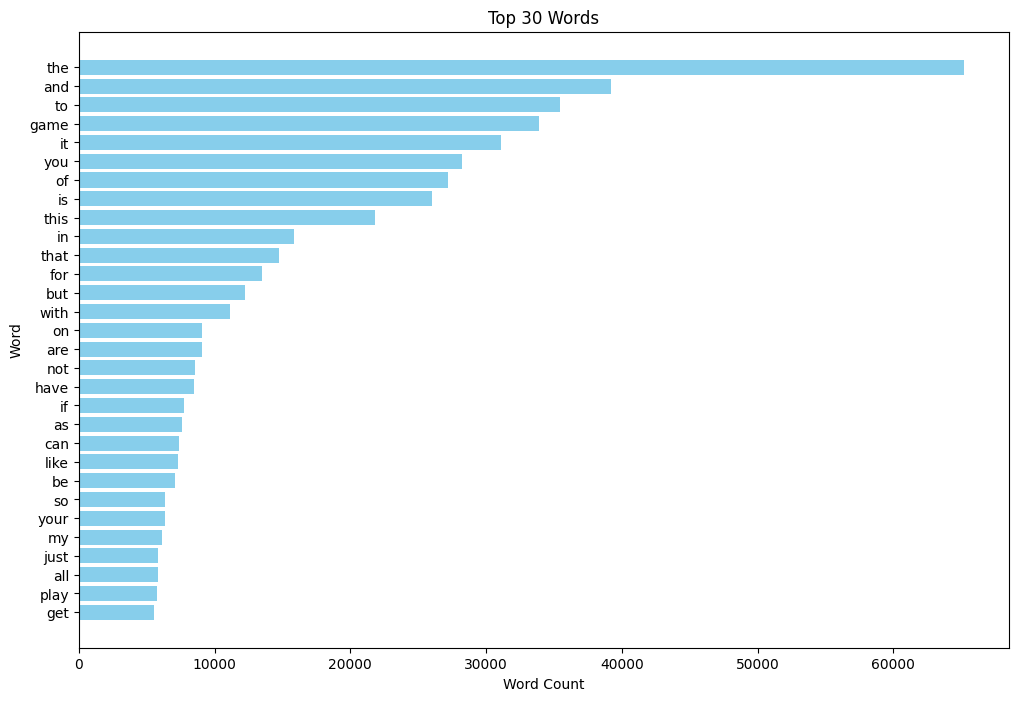

In [47]:
# plot the top 30 words
plt.figure(figsize=(12, 8))
plt.barh(list(sorted_dict.keys())[-30:], list(sorted_dict.values())[-30:], color='skyblue')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.title('Top 30 Words')
plt.show();


Summary:
* We can see the top 30 words here are mostly stop words, so I vote for **now we will remove the stopwords.**
* This is where the "Science" in Data Science comes in to play because there are varying approaches and we can certainly go back and create an alternate dataframe WITH the stopwords as well.

## Applying the Text Cleaning Function
* As mentioned above we want to do this in a methodical order.
* The functions we are not going to use (at first) below are:
1. `to_lowercase()`
2. `expand_contractions()` --> not using this because removing punctuations
3. `Lemmatizer()`

In [48]:
## lets look at df head again
df_reviews_2.head()

,app_id,review_text,review_score,review_votes
0,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
1,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
2,10,Game will be played forever,1,0
3,10,i can't stop playing :D,1,0
4,10,Good The best game,1,0


In [106]:
## putting these in order is important!
def cleaning(df, review):
  ## make copy of dataframe
    df_processed = df.copy()
  ## apply text cleaning functions
    df_processed[review] = df_processed['review_text']
    df_processed[review] = df_processed[review].apply(expand_contractions) ## expand contractions
    df_processed[review] = df_processed[review].apply(clean) ## clean miscellaneous characters
    df_processed[review] = df_processed[review].apply(remove_html_tags) ## removes any tags not in `clean` function
    df_processed[review] = df_processed[review].apply(remove_url) ## removes urls
    df_processed[review] = df_processed[review].apply(rem_emoji) ## remove emojis
    df_processed[review] = df_processed[review].apply(replace_heart_with_PAD) ## replace heart emojis
    df_processed[review] = df_processed[review].apply(remove_num) ## remove numbers
    df_processed[review] = df_processed[review].apply(remove_symbols) ## remove symbols
    df_processed[review] = df_processed[review].apply(standardize_accented_chars) ##standardize accented characters
    df_processed[review] = df_processed[review].apply(remove_punct) ## removing punctuations will mean we can't expand contractions
    df_processed[review] = df_processed[review].apply(remove_stopwords) ## dont remove stopwords for now
    df_processed[review] = df_processed[review].apply(unify_whitespaces) ## normalize whitespaces
    #df_processed[review] = df_processed[review].apply(to_lowercase) ## lowercase all text
    df_processed[review] = df_processed[review].apply(Stemming) ## stemming
    #df_processed[review] = df_processed[review].apply(Lemmatizer, nlp) ##lemmatizing


    return df_processed

## apply the function to df_reviews_2
df_processed = cleaning(df_reviews_2, 'review_text_clean')

<ipython-input-36-f8044a586a3b>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text()
<ipython-input-36-f8044a586a3b>:5: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text()


In [107]:
## view output head
df_processed.head(10)

,app_id,review_text,review_score,review_votes,review_text_clean
0,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1,think got skill came cs go think got skill came cod think got skill bought fallout still got money left steam account well let tell stori go suck alot
1,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0,delet comment want give serious review game delet older one ya go older counter strike peopl know peopl usual find enjoy play due either date glitchi person tend enjoy game time time origin game made first sourc engin old school shooter general shabbi either due game small amount space fill comput rare ever lag make sure interrupt enjoy also competit present counter strike game though seper co...
2,10,Game will be played forever,1,0,game play forev
3,10,i can't stop playing :D,1,0,can not stop play
4,10,Good The best game,1,0,good best game
5,10,really good,1,0,realli good
6,10,10/10,1,0,
7,10,It's ok.,1,0,ok
8,10,"Ok, kinda old and rusty...but, from me it's (G)old =) recommended 100%",1,0,ok kind old rustybut g old recommend
9,10,This game has the graphics of Half-:ife but is an amazing shooter. It has years of expirienced gamers still playing in its servers and... Dang it random person! If you haven't bought this just scroll up and press the buy!,1,0,game graphic half ife amaz shooter year expirienc gamer still play server dang random person bought scroll press buy


## Selecting samples for topic modeling after cleaning
* We will select 2000 samples for topic modeling after cleaning.

In [108]:
## selecting samples for topic modeling after cleaning
neg_reviews = df_processed[df_processed.review_score == 0]

neg_reviews = neg_reviews.sample(n = 2000, random_state=1234)


## here we create a big list of all of the reviews for modeling
all_intents = neg_reviews.review_text_clean.tolist()

# print neg_reviews shape
print(f"Negative reviews shape: {neg_reviews.shape}")

Negative reviews shape: (2000, 5)


In [109]:
## head
neg_reviews.head()

,app_id,review_text,review_score,review_votes,review_text_clean
4382,218620,"I used to love playing this game for its fantastic co-op, pefect for getting couple of friends and having a good time. But with the microtransactions? Seriously Overkill? Way to kill your modding community. This isn't CS:GO.",0,0,use love play game fantast co op pefect get coupl friend good time microtransact serious overkil way kill mod communiti cs go
23346,50300,"If you want to play the game on easy difficulty than do it, it's probably good. I tried playing it on hard difficulty and it just turns out to be impossible. Apart from the stupidly tedious controls and all but responsive animations( i.e. your character will get stuck between objects, will have an incredibly hard time deciding whether to go out of cover or reload, glitching out really bad, and...",0,0,want play game easi difficulti probabl good tri play hard difficulti turn imposs apart stupid tedious control respons anim ie charact get stuck object incred hard time decid whether go cover reload glitch realli bad lot troubl anyth run straight let finish game stun stupid suicid ai teammat anyth help time go enemi fire die like es tri get better cover keep shoot wall complet ignor enemi besid...
2312,204060,Bad game. Not worth any money.,0,0,bad game worth money
23458,51100,this is my first ever game on steam i have masterd quick scoping and what the ♥♥♥♥! they removed snipers how could they is this a glitch or a mistake if its gone this game is broken,0,0,first ever game steam masterd quick scope remov sniper could glitch mistak gone game broken
24869,7770,"This game is one of the worst X-COM Games ever made. Horrible Graphics. Annoying Voices. Boring. Over Powered weapons can be unlocked early in-game, making the game just a matter of paitence. Window 10 user? Won't allow you to see ANYTHING OTHER THAN THE TOP LEFT CORNER. Sure, the types of weapon isn't in any other X-COM game, but then, the game is just plain off a waste of 5 dollars.",0,1,game one worst x com game ever made horribl graphic annoy voic bore power weapon unlock earli game make game matter paitenc window user allow see anyth top left corner sure type weapon x com game game plain wast dollar


## Detecting multilingual text
* We saw before preprocessing the text there were other languages present.
* Let's see if those languages are still present using the python library `langdetect`.

In [110]:
## install langdetect
!pip install langdetect

In [111]:
## create a function to detect languages
from langdetect import detect_langs

def detect_lang(text):
  try:
    return detect_langs(text)
  except:
    return 'unknown'

In [112]:
## apply this to neg_reviews df --> review_text_clean column
neg_reviews['language_detected'] = neg_reviews['review_text_clean'].apply(detect_lang)

In [113]:
## whats len of the language_detected column
neg_reviews['len_language'] = neg_reviews['language_detected'].apply(lambda x: len(x))

In [114]:
## len_language value_counts
neg_reviews['len_language'].value_counts()

,count
len_language,
1,1624
2,295
3,62
4,10
7,6
5,3


Summary:
* Looks like more than 1 language has been detected, lets see what they are.

In [115]:
## sample the reviews with 1 language detected
neg_reviews[neg_reviews['len_language'] == 1].sample(10)

,app_id,review_text,review_score,review_votes,review_text_clean,language_detected,len_language
24712,70000,"dinos are way too OP. needs to be more than one spawn point on a map so you dont get spawn killed every match. shame. was a good idea, just badly done",0,0,dino way op need one spawn point map get spawn kill everi match shame good idea bad done,[en:0.9999960039433848],1
16259,317470,I got enough time to review the game and it still can't find any server to join. I will change the review until the game is at least playable.,0,0,got enough time review game still can not find server join chang review game least playabl,[en:0.9999964560725279],1
17426,337820,"I was pretty excited to see a god game pop up on steam. Ever since Populus on the Amiga I've loved the genre but The Mims misses the mark for me. Each mission takes place on a floating island, each of which contains new dangers to overcome. The developers have clearly made an effort to give the game a semblence of plot although the transitions between missions feel a bit sudden with no real e...",0,0,pretti excit see god game pop steam ever sinc populus amiga love genr mim miss mark mission take place float island contain new danger overcom develop clear made effort give game semblenc plot although transit mission feel bit sudden real explan littl alien choos next landmass happen everyth left behind last one gameplay part fair simpl plant generat fruit fruit give biomass feed livestock sel...,[en:0.9999951352599125],1
4901,219680,"Not a game. This is a tech demo passing itself off as a game. It's neato and cute, but ultimately not very fun to 'play'. I wish this game could play itself while I do other stuff about the house, because then I'd at least have a charming screensaver... that I spent ten bucks on.",0,0,game tech demo pass game neato cute ultim fun play wish game could play stuff hous would least charm screensav spent ten buck,[en:0.9999962029743666],1
14128,289650,"I have been playing this game less than 1 hour, and this game crashed for 4 times:)...",0,1,play game less hour game crash time,[en:0.9999960807466106],1
429,105600,"So, normally I would highly recommend this game. It is fun and full of content. However, with this new update a bug has been completely destroying me and many others game. Terraria wont even launch, and nothing fixes it. It is currently a waste of space in my steam library, which I can't do anything about. When this problem is fixed, perhaps I'd recommend it once more.",0,0,normal would high recommend game fun full content howev new updat bug complet destroy mani other game terraria even launch noth fix current wast space steam librari can not anyth problem fix perhap would recommend,[en:0.9999963707304009],1
14670,294860,"What a piece of buggy crap, can't even play with the stupid menu keep switch up and down none stop, another fail port, last console port i'll ever ever buy on crapsteam",0,0,piec buggi crap can not even play stupid menu keep switch none stop anoth fail port last consol port ever ever buy crapsteam,[en:0.9999957460044343],1
18257,35460,Worst puzzle game i have played it was way to easy for just 1 hr,0,0,worst puzzl game play way easi hr,[en:0.9999977202310334],1
13315,275850,Do not waste your money if you are watching the e3 video's to get a good compare on how the game is. Go to twitch and watch the gameplay for about 4 hours straight to get some better idea of what you are getting yourself into. Sad I wasted my money on this game now especially with the game breaking issues I've experienced some of which I still am such as stuttering.,0,1,wast money watch e video get good compar game go twitch watch gameplay hour straight get better idea get sad wast money game especi game break issu experienc still stutter,[en:0.9999954591634428],1
3078,208650,"As a game, this seems fine; more of the same, but fine. But Warner Bros. (And or Rocksteady's) treatment of the community has been depressing at best and shameful at worst. I 

In [116]:
## sample the reviews with 2 languages detected
neg_reviews[neg_reviews['len_language'] == 2]

,app_id,review_text,review_score,review_votes,review_text_clean,language_detected,len_language
9586,243060,"Want To Play It, But It Crashes, Its Just To Bad.",0,0,want play crash bad,"[en:0.8571407774656696, so:0.1428581046430136]",2
19345,376730,Really bad FPS. Enemies mindlessly float towards you. Animations are bad. Level design is bland and mindnumblingly boring. Weapon models look like modern art (the bad type). Don't buy it...,0,0,realli bad fps enemi mindless float toward anim bad level design bland mindnumbl bore weapon model look like modern art bad type buy,"[en:0.7142846565495425, da:0.2857146835953229]",2
4376,218620,The good times are over.,0,0,good time,"[hr:0.5714268797924027, so:0.4285707285166499]",2
18491,359320,"It's mostly to scale, thats the problem.",0,0,most scale problem,"[ro:0.7142820748128448, fr:0.28571684821002863]",2
13363,277850,This game is worth maybe 2$. Basically it's 2 mini games that aren't that great. You're looking at maybe an hour max of playtime.,0,0,game worth mayb basic mini game great look mayb hour max playtim,"[en:0.8571402031526973, tl:0.14285731637223903]",2
22984,48700,wtf :@:@:@: 9.99 :@:@ :@ its not normal when fier and sword is 6 $ ;@,0,0,wtf normal fier sword,"[af:0.8571381316283402, en:0.14286152813607622]",2
11470,254440,this game sucks :(,0,0,game suck,"[en:0.5714285339487695, lt:0.42856979009656077]",2
6060,223470,This game is horrible and is made from sociopath people. Just trying to get the 4 cards and delete,0,1,game horribl made sociopath peopl tri get card delet,"[ca:0.8571405068338287, en:0.1428575141226685]",2
6398,224480,"Its a fun game at first, but story is very short and gets boring after a while",0,0,fun game first stori short get bore,"[da:0.7142805445351558, en:0.2857172919193087]",2
19245,374320,Laggy as ♥♥♥♥ please fix...,0,1,laggi pleas fix,"[en:0.5714280428723078, ca:0.4285698260021272]",2


In [117]:
## sample reviews with 3 languages detected
neg_reviews[neg_reviews['len_language'] == 3]

,app_id,review_text,review_score,review_votes,review_text_clean,language_detected,len_language
22702,47700,"Take Command and Conquer, strip out the bases , diversity, mining , ability to have more than ten units at a time, and fun, and you get this title.",0,0,take command conquer strip base divers mine abil ten unit time fun get titl,"[fr:0.5714255819904038, it:0.28571514354007727, en:0.14285831707311747]",3
19523,380150,"A few deaths are funny. The game is clunky, has no skip option and the story is BS",0,0,death funni game clunki skip option stori bs,"[en:0.5714270204408356, da:0.2857147016996957, ro:0.14285627691998604]",3
24682,70,It's shïtty fuçking garbage shåt out from a nïgger's ånus.,0,1,sh tti fu king garbag sh n gger nus,"[sv:0.5714264595212805, id:0.28571421367915484, da:0.14285906326373737]",3
21647,426630,Don't buy this. You are literally paying for a SNES emulator that can only emulate bubsy,0,0,buy liter pay snes emul emul bubsi,"[ro:0.7142806687801473, tl:0.14285764855791744, id:0.1428574483683298]",3
12074,263620,"It feels unfinished and vague, like there's something missing. It had potential. Pros:",0,1,feel unfinish vagu like someth miss potenti pros,"[et:0.5714262206028476, no:0.2857132296524312, en:0.14285707788545152]",3
748,107410,this game wouldn't let me eat boogers!!!!!!!!!!!!!!!!!!!!!!!!!!! (?,0,1,game would let eat booger,"[nl:0.4289046014040329, en:0.428569790460844, af:0.14252443523584413]",3
20925,4000,great game !! i love it,0,0,great game love,"[en:0.5609573646077128, da:0.27561120266543593, no:0.16343143255864975]",3
18444,3590,I cannot play this game. It keeps saying 'Fatal error'. What is going on. Iv'e tried to uninstall it and reinstall it.,0,1,can not play game keep say fatal error go iv e tri uninstal reinstal,"[en:0.5714273935752415, ca:0.28571479734843475, nl:0.1428562587665641]",3
9921,245470,"Well, why do i dislike it? You say. Just because it's not fun, i say.",0,0,well dislik say fun say,"[so:0.7142864289240325, af:0.1428570770951588, tl:0.14285618416031137]",3
18577,359550,Fully armored and gets killed by 1 shield melee... Delete Local Files....I suck at this game.,0,0,fulli armor get kill shield mele delet local filesi suck game,"[it:0.42856971226423046, da:0.2888576886322721, no:0.2825722489581853]",3


In [118]:
## sample reviews with 7 languages detected
neg_reviews[neg_reviews['len_language'] == 7]

,app_id,review_text,review_score,review_votes,review_text_clean,language_detected,len_language
3114,208650,its ♥♥♥♥,0,0,,unknown,7
17447,338180,♥♥♥♥ that ♥♥♥♥,0,0,,unknown,7
17365,335330,"....................../´¯/) ....................,/¯../ .................../..../ ............./´¯/'...'/´¯¯`·¸ ........../'/.../..../......./¨¯\ ........('(...´...´.... ¯~/'...') .........\.................'...../ ..........''...\.......... _.·´ ............\..............( ..............\.............\...",0,1,,unknown,7
14825,298630,Its a ♥♥♥♥,0,0,,unknown,7
6376,224260,0/10,0,0,,unknown,7
17250,333930,https://www.youtube.com/watch?v=_ZnXKFuCUGo,0,0,,unknown,7


Summary:
* For the most part it appears that the other languages detected are not other languages (other than a few lines of french).
* However, the "social media" type of writing makes it appear as another language.

Let's go back to what we were doing -- topic modeling and look at the `all_intents` text.
* We can say that after that brief experiment detecting languages that there really is no need for multilingual embeddings based on the sample of text that we extracted.

In [119]:
## all intents
all_intents

['use love play game fantast co op pefect get coupl friend good time microtransact serious overkil way kill mod communiti cs go',
 'want play game easi difficulti probabl good tri play hard difficulti turn imposs apart stupid tedious control respons anim ie charact get stuck object incred hard time decid whether go cover reload glitch realli bad lot troubl anyth run straight let finish game stun stupid suicid ai teammat anyth help time go enemi fire die like es tri get better cover keep shoot wall complet ignor enemi besid result get knife stab time can not trust back enemi come without anyth possibl one worst ai ever seen game heal everi flippin second dumb know great stori get collect intel listen enemi dialogu enough keep motiv play piec',
 'bad game worth money',
 'first ever game steam masterd quick scope remov sniper could glitch mistak gone game broken',
 'game one worst x com game ever made horribl graphic annoy voic bore power weapon unlock earli game make game matter paitenc 

## Removing Sentences with less than 4 words
* This is user choice. You can decide what sentence length you want to use.

In [120]:
## create sent list
all_sents = []

## loop through and tokenize
for intent in all_intents:
  for sent in nltk.sent_tokenize(intent):
    if len(sent.split()) > 4:
      ## append sentence
      all_sents.append(sent)

## print len of sentences
print(f"Len of all_sents: {len(all_sents)}")


## assign all_sents to all_intent
all_intent = all_sents

Len of all_sents: 1747


# Sentence Embeddings
* Now we can create sentence embeddings using SentenceTransformers.

In [64]:
!pip install sentence_transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [65]:
## import sentence transformers
from sentence_transformers import SentenceTransformer
## import tensorflow
import tensorflow as tf

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Sentence Transformer Models
* We are going to use the `all-mpnet-base-v2` since it is well known for mapping sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like **clustering or semantic search**.
* HuggingFace model card: https://huggingface.co/sentence-transformers/all-mpnet-base-v2

In [66]:
## setup device agnostic code
## if using pytorch you would use this but we are using TF -- TF is agnostic
## device = "cuda" if torch.cuda.is_available() else "cpu"
## device

In [67]:
## check for gpu
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [121]:
## function for creating embeddings
%%time

def embed(model, model_type, sentences):
  if model_type == 'use':
    embeddings = model(sentences)
  elif model_type == 'sentence transformer':
    embeddings = model.encode(sentences)

  return embeddings


## instantiate SentenceTransformer
model_st1 = SentenceTransformer('all-mpnet-base-v2', device='cpu') ## set to cpu or cuda

## create embeddings
embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents)


CPU times: user 6min 48s, sys: 43.9 s, total: 7min 32s
Wall time: 7min 40s


In [122]:
## check shape of embeddings
embeddings_st1.shape

(2000, 768)

Summary:
* We now have 2000 embeddings of 768 dimension.

# Dimensionality Reduction
* This is commonly done before clustering or topic modeling.
* Generally speaking this is best practice for unsupervised ML techniques. There are many papers out there that support this.
* Why do we reduce dimensionality?
  * **"Curse of Dimensionality"**
  * Distance metrics become essentially meaningless at high dimensions such as we have here in our embeddings (768).
  * Thus reducing dimensions allows the distance metrics (e.g. euclidean distance, manhattan distance) to perform better.
  * However, some SentenceTransformer models have been optimized for their dimensionality so one would think its not necessary to do this.
  * It really depends on your dataset, use case(s), and results needed. Generally speaking you will get better results by reducing the vector space first before topic modeling but it is important to experiment.

## UMAP - Uniform Manifold Approximation and Projection
* UMAP is similar to t-SNE, as it is a non linear method for dimension reduction, so it aims to represent high-dimensional data in a lower-dimensional space while preserving both local and global structure.
* However, the algorithm utilizes a different mathematical approach than t-SNE, which can lead to different trade-offs and results.
* UMAP is based on the concept of constructing a fuzzy topological representation of high-dimensional data and then optimizing the low-dimensional representation to be as close as possible to the fuzzy topological structure.
   * It leverages ideas from manifold learning, graph theory, and Riemannian geometry.
* Key Features of UMAP:

1. **Preserves Local and Global Structure**
  * UMAP aims to preserve both local and global structure in the data when mapping it to a lower-dimensional space.
2. **Flexibile Parameter Tuning**
  * UMAP provides several parameters that can be adjusted to control the trade-off between preserving local versus global structure, as well as other aspects of the embedding.
3. **Scalability**
  * UMAP is known for its scalability and ability to handle large datasets efficiently.
  * UMAP utilizes an approximate nearest neighbor (ANN) search algorithm, which allows it to scale to millions of data points.
4. **Speed**
  * UMAP is generally faster than some other dimensionality reduction techniques, such as t-SNE.

### UMAP Parameters to know
* **n_neighbors**
  * determines the number of nearest neighbors used to construct the neighborhood graph.
  * increasing n_neighbors can capture more global structure, but may also increase computation time.
  * typical values are between 5 and 50, depending on the size and density of the dataset.
* **min_dist**
  * controls the minimum distance between points in the low-dimensional embedding.
  * smaller values of min_dist allows for tighter clustering, but can result in overfitting and crowded visualizations.
  * increasing min_dist encourages more even spacing between points.
* **n_components**
  * specifies dimensionality of the low-dimensional embedding.
  * default is set to 2, which allows for visualization in a 2D plot. However, you can choose a higher value to obtain a higher-dimensional embedding if needed.
* **metric**
  * UMAP supports various distance metrics to measure similarity between data points in the high-dimensional space.
  * default metric is **Euclidean distance** but you can try with other metrics like **manhattan, cosine, mahalanobis, etc...**
* **random_state**
  * if we need to have reproducibility in our results, we can set a seed by using random_state.

In [70]:
## need to install libraries first
!pip install UMAP hdbscan

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 55.9 MB/s eta 0:00:00
  Created wheel for UMAP: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=f59532a0ff5412f2456ae024cd13744383b1aec1296e231555e5faeff487abbb
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built UMAP


### Bayesian Optimization
* As part of the clustering we will use Bayesian Optimization.
* Bayesian optimization is also called **Sequential Model-Based Optimization (SMBO).**
   * It finds the value that minimizes an objective function by building a surrogate function.
   * A surrogate function is nothing but a probability model based on past evaluation results of the objective.
   * In the surrogate function, the input values to be evaluated are selected based on the criteria of expected improvement.
   * Bayesian methods use past evaluation results to choose the next input values. So, this method excludes the poor input values and limit the evaluation of the objective function by choosing the next input values which have done well in the past.

* Currently, there are numerous Python libraries that allow us to implement Bayesian Optimization for machine learning models.
* These include:
   * Spearmint
   * SMAC
   * Hyperopt
   * Scikit-optimize (skopt)
   * Optuna
   * Optunity

* Bayesian Optimization methods differ in how they construct the surrogate function for optimization.
   * Spearmint uses Gaussian Process surrogate
   * SMAC uses Random Forest Regression
   * Hyperopt uses the Tree Parzen Estimator (TPE)
     * docs: https://hyperopt.github.io/hyperopt/?source=post_page
   * Scikit-optimize uses:
      * 1. forest_minimize(decision tree regression search)
      * 2. gbrt_minimize (gradient-boosted-tree regression search)
      * 3. gp_minimize (Gaussian Process Regression Search)

   * Optuna uses Tree-structured Parzen Estimator (TPE) - same as Hyperopt
* Paper comparing a few of the algos: https://arxiv.org/pdf/2201.06433


Following are the 4 most common methods of hyperparameter optimization for machine learning in **order of increasing efficiency**:
1. Manual
2. Grid search
3. Random search
4. Bayesian model-based optimization
* Why is Bayesian optimization most efficient? It builds a probability model of the objective function and uses it to select the most promising hyperparameters to evaluate in the true objective function.

In [71]:
## imports
import umap ## dimensionality reduction
import hdbscan ## clustering algorithm
from functools import partial
import random

## For Bayesian Optimization search of optimal hyperparameters --> using hyperopt package
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

### Quick Review of Unsupevised ML Clustering Techniques
1. Partition Clustering
* Types include:
   * 1. K-means
   * 2. Spectral
   * 3. Affinity
* K-means clustering is the most commonly used algorithm as it is the most interpretable.
  * However, k-means has its drawbacks such as:
    * n_clusters can be subjective and not exact. Even using the "elbow method" or "silhouette score" or "WCSS" (within cluster sum of squares) or other related algorithms are not 100% perfect.
    * K-means is also predominantly a **"partitioning"** algorithm not really a true clustering algorithm.
       * Partition-based clustering is a type of clustering algorithm that divides the dataset into a set of **non-overlapping clusters**.
       * This means each data point belongs to exactly 1 cluster.
       * These algorithms iteratively refine the partitioning of the data based on certain criteria, such as minimizing the intra-cluster distance or maximizing the inter-cluster distance.
  * Common issues seen as well with these are:
    * 1. 'Noise'
    * 2. 'Outliers'
       * This means that the clusters are not "pure".

2. Hierarchical
   * Agglomerative
   * Divisive
3. Density Based
   * HDBSCAN
   * Density-based clustering is a type of clustering algorithm that identifies clusters in a dataset based on the **density of data points.**
   * This means that NOT every data point has to be assigned to a cluster. Non-assigned points are "outliers or noise."
   * Unlike partition-based algorithms like K-means or hierarchical clustering, density-based clustering **does not require a predefined number of clusters and can find clusters of arbitrary shape and size.**
   * Instead, it groups data points that are:
      * 1. closely packed in high-density regions
      * 2. marking points in low-density regions as outliers or noise

* Sources:
1. https://medium.com/@avicsebooks/ml-part-5-clustering-00d30a977b50
2. https://pberba.github.io/stats/2020/01/17/hdbscan/
3. HDBSCAN arxiv paper: https://arxiv.org/pdf/1705.07321




HDBSCAN notes about parameters
* `cluster_selection_method` - default is "eom" or "excess of mass".
   * This may not be ideal if you don't want large clusters.
   * Instead if you want smaller clusters, 'leaf' is the other option.
* see documentation: https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

In [72]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.0 MB/s eta 0:00:00


In [73]:
import umap.umap_ as umap

In [123]:
## function for generating clusters
def generate_cluster(message_embeddings,
                     n_neighbors, #UMAP
                     n_components, #UMAP
                     min_cluster_size, #HDBSCAN
                     min_samples = None, #HDBSCAN last 2 params
                     random_state = None):

  # 1. generate UMAP embeddings --> from message_embeddings
  umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, n_components=n_components,
                               metric='cosine', random_state=42)).fit_transform(message_embeddings)


  # 2. HDBSCAN clusters
  clusters = hdbscan.HDBSCAN(min_cluster_size= min_cluster_size,
                             min_samples=min_samples,
                             metric='euclidean',
                             gen_min_span_tree=True,
                             cluster_selection_method='eom').fit(umap_embeddings) ## fit the umap embeddings

  return clusters


## Bayesian Optimization with Hyperopt
* See the details I wrote above.
* This is how we will optimize the model hyperparameters.

**Setup Cluster Labeling Function**

In [124]:
## labeling and scoring the clusters
def score_clusters(clusters, prob_threshold=0.05):
  """Function takes in clusters and uses probability threshold to determine cluster labels"""

  ## store the cluster labels in array
  cluster_labels = clusters.labels_

  ## unique label count
  label_count = len(np.unique(cluster_labels))
  ## total num of cluster labels
  total_num = len(clusters.labels_)

  # cost -- fraction of data points that have probability below cutoff threshold (0.05)
  cost = np.count_nonzero(clusters.probabilities_ < prob_threshold) / total_num ## total_num of clusters

  return label_count, cost


**Setup Hyperopt hyperparameter tuning function**

In [125]:
## hyperopt function for hyperparameter tuning
##
def objective(params, embeddings, label_lower, label_upper):
  """Function that uses hyperopt to determine optimal hyperparameters
  Args:
  - param: parameters (dictionary or paramters)
  - embeddings: embeddings
  - label_lower: lower range of expected clusters
  - label_upper: upper range of expected clusters

  Returns:
     dict: Dictionary containing loss value, num of unique cluster labels, and status.
  """
  # cluster defined
  clusters = generate_cluster(embeddings,
                             n_neighbors=params['n_neighbors'],
                             n_components=params['n_components'],
                             min_cluster_size=params['min_cluster_size'],
                             random_state=params['random_state'])

  ## label_count, cost
  label_count, cost = score_clusters(clusters, prob_threshold=0.05)

  # add penalty on cost function -- when outside of range -- set at 100% but can change
  if (label_count < label_lower) | (label_count > label_upper):
    penalty = 1.0
  else:
    penalty = 0

  # define loss
  loss = cost + penalty

  return {'loss' : loss, 'label_count' : label_count, 'status' : STATUS_OK}


**Setup Bayesian Search function**
* These are the 4 most common methods for hyperparameter optimization in machine learning in order of increasing efficiency:
1. Manual
2. Grid Search
3. Random Search
4. Bayesian model-based optimization
  * Builds a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.
  * Uses bayesian probability to determine best parameters given the previous parameters.
  * Hyperopt documentation, getting started: https://github.com/hyperopt/hyperopt/wiki/FMin

In [126]:
## function for bayesian search
def bayesian_search(embeddings, space, label_lower, label_upper, max_evals = 100):
  ## define trials storage object
  trials = Trials()
  ## define fmin - function to minimize
  fmin_objective = partial(
      objective,
      embeddings=embeddings,
      label_lower=label_lower,
      label_upper=label_upper
  )
  ## best result -- space is the search space
  best = fmin(fmin_objective,
              space = space,
              algo = tpe.suggest,
              max_evals = max_evals,
              trials = trials,
  )

  ## best params
  best_params = space_eval(space, best)
  print('best_params: ', best_params)
  print(f"label count : {trials.best_trial['result']['label_count']}")

  ## get the best clusters --> generate_cluster function (UMAP + HDBSCAN results)
  best_clusters = generate_cluster(embeddings,
                                   n_neighbors = best_params['n_neighbors'],
                                   n_components = best_params['n_components'], # n_components comes from best_params
                                   min_cluster_size = best_params['min_cluster_size'],
                                   random_state = best_params.get('random_state', None) #.get with default value
                                   )

  return best_params, best_clusters, trials


### Define hspace
* hyperparameter search space
* Note: `hspace` is the `space` parameter in the `bayesian_search()` function above.

In [127]:
## define space
## "hp" was imported from hyperopt
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,32)),
    "n_components": hp.choice('n_components', range(3,32)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,32)),
    "random_state": 42
}

label_lower = 10
label_upper = 100
max_evals = 25 # change to 50 or 100 for extra steps as needed

### Bayesian Search - Implementation

In [128]:
%%time

## bayesian search
best_param_use, best_clusters_use, trials_use = bayesian_search(embeddings_st1,
                                                                space=hspace,
                                                                label_lower=label_lower,
                                                                label_upper=label_upper,
                                                                max_evals=max_evals)

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  4%|▍         | 1/25 [00:16<06:43, 16.80s/trial, best loss: 0.572]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  8%|▊         | 2/25 [00:32<06:08, 16.03s/trial, best loss: 0.572]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 12%|█▏        | 3/25 [00:45<05:26, 14.86s/trial, best loss: 0.572]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 16%|█▌        | 4/25 [01:01<05:18, 15.16s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 20%|██        | 5/25 [01:16<05:03, 15.19s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 24%|██▍       | 6/25 [01:31<04:46, 15.06s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 28%|██▊       | 7/25 [01:45<04:26, 14.80s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 32%|███▏      | 8/25 [01:59<04:08, 14.59s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 36%|███▌      | 9/25 [02:11<03:39, 13.73s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 40%|████      | 10/25 [02:26<03:32, 14.16s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 44%|████▍     | 11/25 [02:39<03:10, 13.59s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 48%|████▊     | 12/25 [02:53<02:58, 13.71s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 52%|█████▏    | 13/25 [03:11<03:01, 15.14s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 56%|█████▌    | 14/25 [03:24<02:39, 14.48s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 60%|██████    | 15/25 [03:35<02:15, 13.51s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 64%|██████▍   | 16/25 [03:47<01:56, 12.94s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 68%|██████▊   | 17/25 [04:01<01:46, 13.34s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 72%|███████▏  | 18/25 [04:18<01:40, 14.29s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 76%|███████▌  | 19/25 [04:33<01:28, 14.68s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 80%|████████  | 20/25 [04:50<01:16, 15.33s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 84%|████████▍ | 21/25 [05:06<01:02, 15.58s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 88%|████████▊ | 22/25 [05:19<00:44, 14.75s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 92%|█████████▏| 23/25 [05:32<00:28, 14.33s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 96%|█████████▌| 24/25 [05:44<00:13, 13.61s/trial, best loss: 0.478]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



100%|██████████| 25/25 [05:59<00:00, 14.37s/trial, best loss: 0.478]
best_params:  {'min_cluster_size': 4, 'n_components': 28, 'n_neighbors': 16, 'random_state': 42}
label count : 79


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


CPU times: user 6min 11s, sys: 1.03 s, total: 6min 12s
Wall time: 6min 15s


### Print Sentences for a given cluster
* **We should also remember that depending on how you preprocess your text your results will differ.**
  * For example, I did not remove stop words which may cause some of the topics to be different if you had removed the stop words.
  * I also did not stem or lemmatize the text and instead I converted contractions to full words.
  * Pre-processing is dependent on your data and use case(s).
* Reminder, based on the bayesian search above we had the following cluster results:

best_params:
* `min_cluster_size`: 4
* `n_components`: 28,
* `n_neighbors`: 16,
* `random_state`: 42
* `label count`: 79

Notes:
* Without removing stop words there are 10 clusters.
* WITH removing stop words there are 79 clusters -- interesting!

In [130]:
## cluster 2
C_ = 2

for index, clust in enumerate(best_clusters_use.labels_):
  if clust == C_:
    print(all_intents[index])

want tri multiplay wife can not host multiplay without give money uninstal
host connect last play sort actual multiplay worth waist time download vanilla version
good singl player multiplay say loadout kid cool
split screen player
multiplay work nomorecoop
peopl left multiplay
connect multyplay


# Automatic Cluster Labeling
* We can use spacy for part of speech labeling.
* The core idea is to:
1. Most common verb and top 2 nouns to build cluster topic labels.
2. This is based on the paper: https://arxiv.org/pdf/2104.12114

In the paper they describe the objective of this technique:
1. Generate an intent label automatically for each cluster.
2. Extract the ACTION-OBJECT (VERB-NOUN) pair from each utterance using a dependency parser.
3. Take the most frequent pair within each cluster, e.g. "book-restaurant" as the generated intent label.

Unsupervised Open Intent Discovery Tasks
1. Automatically discovering intents from a corpus of raw conversational data.
2. Automatically assigning each utterance in the corpus to the discovered intent.


## Building the ACTION-OBJECT pair
* spacy to label data
* Use our cluster labels

In [96]:
import collections
import spacy
## import displacy
from spacy import displacy

## setup spacy nlp object
nlp = spacy.load('en_core_web_sm')

Data Cluster needs to be a pandas dataframe

In [131]:
## create cluster dataframe - list + zip all_intents with best_clusters_use.labels_
data_clustered = pd.DataFrame(data = list(zip(all_intents, best_clusters_use.labels_)),
                              columns=['text', 'label_st1'])


## head of clusters and labels
data_clustered.head()

,text,label_st1
0,use love play game fantast co op pefect get coupl friend good time microtransact serious overkil way kill mod communiti cs go,20
1,want play game easi difficulti probabl good tri play hard difficulti turn imposs apart stupid tedious control respons anim ie charact get stuck object incred hard time decid whether go cover reload glitch realli bad lot troubl anyth run straight let finish game stun stupid suicid ai teammat anyth help time go enemi fire die like es tri get better cover keep shoot wall complet ignor enemi besid...,-1
2,bad game worth money,-1
3,first ever game steam masterd quick scope remov sniper could glitch mistak gone game broken,66
4,game one worst x com game ever made horribl graphic annoy voic bore power weapon unlock earli game make game matter paitenc window user allow see anyth top left corner sure type weapon x com game game plain wast dollar,-1


In [132]:
## lets get the label_st1 value_counts
data_clustered['label_st1'].value_counts()

,count
label_st1,
-1,954
67,153
62,54
65,38
18,35
47,30
76,27
8,26
24,24


In [133]:
## labels example_category
example_category = data_clustered[data_clustered['label_st1'] == 2].reset_index(drop = True)

#head
example_category.head()

,text,label_st1
0,want tri multiplay wife can not host multiplay without give money uninstal,2
1,host connect last play sort actual multiplay worth waist time download vanilla version,2
2,good singl player multiplay say loadout kid cool,2
3,split screen player,2
4,multiplay work nomorecoop,2


# Find the IDF (inverse document frequency) of every word
* Inverse document frequency examines how common (or uncommon) a word is amongst a text corpus.
* IDF is calculated as follows:
  * where t is the term (word) we are looking to measure the commonness of * N is the number of documents (d) in the corpus (D)
  * The denominator is the number of documents in which the term, t, appears in.


  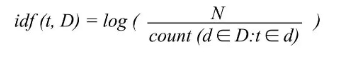



## Why would we need to calculate the IDF here?
* We came up with the most common words in each cluster (e.g. game, played)
* If a word appears in every cluster it is probably not as important as a rare word might be.


In [134]:
## import Counter
from collections import Counter

# list for sentences with word lemma
sent_with_word_lemma = []

#iterate through all_intents
for intent in all_intents:
  doc = nlp(intent)
  temp_sent = ""
  this_one = False
  for token in doc:
    ## search for: verb, noun, adj, or dependent object
    if(token.pos_ in ['VERB', 'NOUN','ADJ'] or (token.dep_ == 'dobj')):
      ## append to temp_sent
      temp_sent += token.lemma_.lower() + " "
  # append temp sent to sent_with_word_lemma
  sent_with_word_lemma.append(temp_sent)


In [135]:
## check first 3
sent_with_word_lemma[:3]

['use love play game fantast co pefect get friend good time microtransact serious overkil way kill communiti go ',
 'want play game difficulti probabl good play hard difficulti turn imposs stupid tedious control respon anim get stuck object incred hard time decid go cover bad lot troubl anyth run let finish game stupid help time go enemi fire die get well cover keep shoot result get knife time trust enemi come possibl bad see game heal flippin second dumb know great stori get collect listen enemi dialogu enough keep motiv play piec ',
 'bad game worth money ']

## Define IDF Function

In [136]:
## define IDF function
def compute_IDF(documents):
  word_count = Counter() ##unordered dict with elements + counts
  for doc in documents:
    if 'drops(players' in doc:
      print(doc)
    word_set = set(doc.split())
    word_count.update(word_set)

  print(word_count)
  total = sum(word_count.values())
  # TF-IDF calculation in dictionary
  word_IDF = {k : round((np.log2(total / v))) for k, v in word_count.items() }

  return word_IDF


## Compute IDF

In [137]:
## compute IDF
word_IDF = compute_IDF(sent_with_word_lemma)
word_IDF

Counter({'game': 1376, 'play': 712, 'get': 588, 'time': 399, 'make': 389, 'good': 382, 'buy': 335, 'bad': 309, 'go': 295, 'say': 251, 'want': 246, 'fun': 246, 'thing': 226, 'money': 225, 'feel': 222, 'hour': 219, 'look': 214, 'see': 208, 'way': 203, 'recommend': 203, 'think': 198, 'work': 190, 'use': 189, 'much': 184, 'give': 184, 'take': 176, 'start': 173, 'stori': 172, 'find': 171, 'graphic': 169, 'great': 164, 'run': 163, 'know': 156, 'first': 155, 'worth': 153, 'new': 152, 'pay': 145, 'actual': 143, 'seem': 134, 'control': 133, 'end': 133, 'fix': 133, 'need': 133, 'lot': 132, 'enjoy': 130, 'gameplay': 130, 'player': 130, 'come': 129, 'well': 127, 'level': 127, 'point': 126, 'peopl': 124, 'crash': 123, 'review': 122, 'free': 115, 'someth': 115, 'kill': 112, 'steam': 112, 'tri': 112, 'complet': 111, 'develop': 110, 'love': 108, 'system': 106, 'pc': 106, 'spend': 105, 'year': 104, 'reason': 103, 'set': 101, 'everi': 100, 'terribl': 99, 'keep': 98, 'let': 96, 'problem': 95, 'bug': 93, 

{'friend': 9,
 'overkil': 13,
 'pefect': 16,
 'communiti': 11,
 'way': 8,
 'co': 12,
 'time': 7,
 'play': 6,
 'love': 9,
 'go': 7,
 'microtransact': 11,
 'game': 5,
 'get': 6,
 'serious': 10,
 'kill': 9,
 'fantast': 12,
 'good': 7,
 'use': 8,
 'anyth': 10,
 'dumb': 11,
 'collect': 11,
 'anim': 10,
 'second': 9,
 'trust': 13,
 'probabl': 10,
 'decid': 10,
 'want': 8,
 'finish': 10,
 'fire': 11,
 'know': 8,
 'listen': 12,
 'heal': 13,
 'troubl': 12,
 'hard': 9,
 'come': 9,
 'lot': 8,
 'motiv': 13,
 'respon': 12,
 'tedious': 12,
 'stupid': 10,
 'keep': 9,
 'enough': 9,
 'stuck': 12,
 'well': 9,
 'dialogu': 11,
 'see': 8,
 'control': 8,
 'imposs': 11,
 'difficulti': 11,
 'help': 10,
 'let': 9,
 'turn': 9,
 'bad': 7,
 'cover': 11,
 'run': 8,
 'stori': 8,
 'enemi': 10,
 'die': 9,
 'shoot': 9,
 'great': 8,
 'piec': 11,
 'object': 11,
 'flippin': 16,
 'result': 11,
 'knife': 13,
 'incred': 11,
 'possibl': 11,
 'worth': 8,
 'money': 8,
 'masterd': 16,
 'quick': 10,
 'sniper': 13,
 'steam': 9,
 

Summary:
* We now have the IDF for each word.
* We now want to give different weights to each word.
* You can notice I did remove the stop words so there are more topics now. There are certain nuances to text preprocessing and this can effect the result of your topics.

# Automatic Cluster Labeling

### Here is what we will do:
* Concatenate the most common verb, direct object, and top 2 nouns from each cluster for the Automatic Cluster Labeling we just did.

In [152]:
#1. function to return documents of single category
def get_group(df, category_col, category):
  single_category = df[df[category_col] == category].reset_index(drop=True)
  return single_category

#2. Get the most common category in a list of words
def most_common(lst, n_words, word_IDF={}):
  ## takes in a list and returns a dict with values
  counter = collections.Counter(lst)
  ## iterate and give different weights to different words
  for k in counter:
    if counter[k] == 1:
      pass
    else:
      if k in word_IDF:
        counter[k] *= word_IDF[k]

  return counter.most_common(n_words)


In [153]:
#3. Extracting labels from docs in same clusters
## concat most common verb, dir obj, top 2 nouns for each cluster

def extract_labels(category_doc, print_word_counts = False):
  '''
  Argument:
      category_docs: list of documents, all from same category or clustring. category_docs is a list of strings such as below
      ['fun game small amount time unless lifer.....', ... 'steem pile graphic']

      print_word_counts: bool, True will print word counts of each type in this category
  '''
  ## empty lists
  verbs = []
  dobjs = []
  nouns = []
  adjs = []

  ## empty strings
  verb = ''
  dobj = ''
  noun1 = ''
  noun2 = ''

  ## append each POS for each cluster
  for i in range(len(category_doc)):
    # create spacy doc
    doc = nlp(category_doc[i])
    for token in doc:
      if (token.is_stop == False) and (len(str(token).strip()) > 0):
        if token.pos_ == 'VERB':
          verbs.extend([token.lemma_.lower()])

        elif token.dep_ == 'dobj':
          dobjs.extend([token.lemma_.lower()])

        elif token.pos_ == 'NOUN':
          nouns.extend([token.lemma_.lower()])

        elif token.pos_ == 'ADJ':
          adjs.extend([token.lemma_.lower()])

  # print('most_common(verbs, 1) ', most_common(verbs, 1))
  ## output would be: [('m', 27)]
  if print_word_counts:
    for word_lst in [verbs, dobjs, nouns, adjs]:
      counter = collections.Counter(word_lst)
      print(counter)

  ## most common words of each POS tag
  if len(verbs) > 0:
    verb = most_common(verbs, 1)[0][0]

  if len(dobjs) > 0:
    dobj = most_common(dobjs, 1)[0][0]

  if len(nouns) > 0:
    noun1 = most_common(nouns, 1)[0][0]

  if len(verbs) > 1:
    noun2 = most_common(verbs, 2)[0][0]

  # concatenate most common verb-dobj-noun1-noun2 (if they exist!)
  label_words = [verb, dobj]

  ## concat nouns
  for word in [noun1, noun2]:
    if word not in label_words:
      label_words.append(word)

  if '' in label_words:
    label_words.remove('')

  label = '_'.join(label_words)

  return label





In [155]:
## check function output
current_cat = [
    'use love play game fantast co pefect get friend good time microtransact serious overkil way kill communiti go ',
 'want play game difficulti probabl good play hard difficulti turn imposs stupid tedious control respon anim get stuck object incred hard time decid go cover bad lot troubl anyth run let finish game stupid help time go enemi fire die get well cover keep shoot result get knife time trust enemi come possibl bad see game heal flippin second dumb know great stori get collect listen enemi dialogu enough keep motiv play piece ',
 'bad game worth money '
]

x = extract_labels(current_cat)
x

'use_pefect_game'

Summary:
* Action-Object pair is the resulting label here.

## Getting output for `data_clustered` dataframe

In [158]:
## get group() labels
list(get_group(data_clustered, 'label_st1', 24)['text'])

['kind bore',
 'fun get old',
 'eh bother fast enough',
 'well dislik say fun say',
 'actual fun would recommend pay',
 'plain fun',
 'keep run shut curious',
 'game fun',
 'stay away fun game',
 'fun play',
 'realli slow pace grew bore quick puzzl pretti difficult fun way',
 'get bore fast',
 'ok quick loss fun',
 'bore',
 'fun',
 'like get bore',
 'first could fun later dumb af',
 'got bore real quick fun littl though',
 'much fun push turd back butt yes peopl like',
 'pretti hard bore',
 'fun short ing end',
 'fun get even run gfwl gone',
 'fun get bore fast',
 'good bore']

Summary:
* Now we have all the text for cluster 24

# Getting the Automatic Cluster Labels - Final Data

In [160]:
## function to apply and summarize topic clusters with labels
def apply_and_summarize_labels(df, category_col):
  """
    Assign groups to original documents and provide group counts

    Arguments:
        df: pandas dataframe of original documents of interest to
            cluster
        category_col: str, column name corresponding to categories or clusters

    Returns:
        summary_df: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
    """

  ## numerical labels
  numerical_labels = df[category_col].unique()

  # dict num cat to generated label
  label_dict = {}

  for label in numerical_labels:
    current_category = list(get_group(data_clustered, category_col, label)['text'])

    label_dict[label] = extract_labels(current_category)

  # create summary df with numeric labels + counts
  summary_df = (df.groupby(category_col)['text'].count()
                  .reset_index()
                  .rename(columns={'text' : 'count'})
                  .sort_values('count', ascending=False))

  # apply generated labels
  summary_df['label'] = summary_df.apply(lambda x: label_dict[x[category_col]], axis=1)

  return summary_df

In [161]:
## get results
cluster_summary = apply_and_summarize_labels(data_clustered, 'label_st1')
cluster_summary

,label_st1,count,label
0,-1,954,play_game
68,67,153,play_game
63,62,54,play_game
66,65,38,recommend_game
19,18,35,quit_end_game
48,47,30,use_game
77,76,27,feel_game
9,8,26,play_game
25,24,24,run_bore_fun
26,25,22,play_game


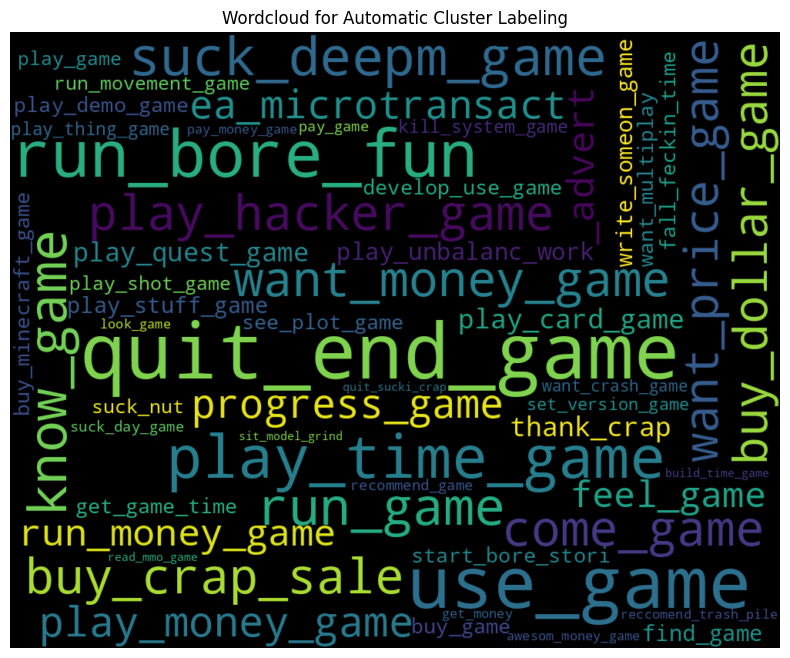

In [166]:
# Generate wordcloud
wordcloud = WordCloud(width=1000,
                      height=800,
                      background_color='black',
                      max_font_size=100,
                      max_words=100,
                      ).generate_from_frequencies(dict(zip(cluster_summary['label'], cluster_summary['count'])))

# Display the generated image:
plt.figure(figsize=(16, 8))
plt.title('Wordcloud for Automatic Cluster Labeling')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();
